In [1]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.utils.misc import get_labels_counts
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction

from src.ml.loso import run_same_side_classifications, run_different_classifications

# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# Data Preparation

## Cognitive Load Info

In [2]:
path_to_experiment_info: str = "../data.nosync/usilaughs/all_experimento_info.csv"
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=1)

## Physiological Data

In [3]:
eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/67 [00:00<?, ?it/s]

528

In [4]:
users = get_all_users(eda_data)
sessions_all = ["experiment"]
output_folder: str = "../visualizations/"
for user in tqdm(sorted(users), desc="Plotting user data", colour="red"):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data={"EDA": eda_data},
            user_id=user,
            session_id=session,
            dataset="usi_laughs",
            experiment_info=experiment_info.to_df(),
            eda_type="mixed-EDA",
            output_folder=output_folder
        )


Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

In [5]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())

In [6]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [7]:
segment_size_in_secs = 4
eda_sample_rate = 4

segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate
experiment_info_as_dict = experiment_info.to_dict()

In [8]:
(
    values_left,
    values_right,
    labels_left,
    labels_right,
    groups_left,
    groups_right,
) = segment(
    data=eda_data,
    experiment_info_as_dict=experiment_info_as_dict,
    segment_size_in_sampling_rate=segment_size_in_sampling_rate,
    segment_size_in_secs=segment_size_in_secs,
    data_sample_rate=eda_sample_rate,
)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

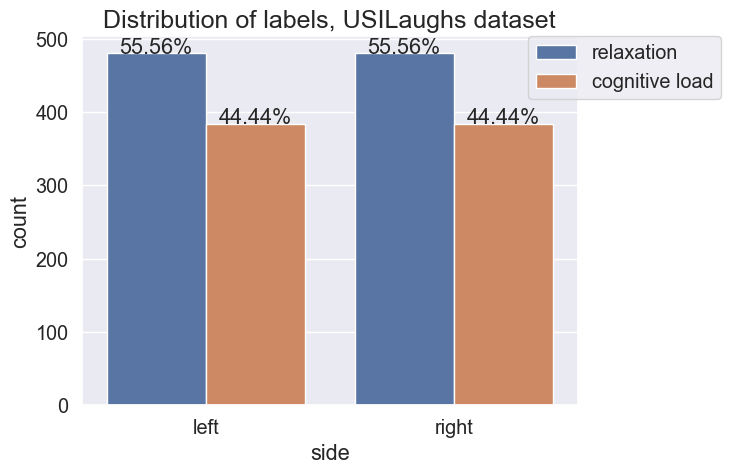

In [9]:
counts = get_labels_counts(labels_left, labels_right, ['relaxation', 'cognitive load'])
plot_binary_labels(
    counts=counts,
    title="Distribution of labels, USILaughs dataset",
    dataset_name="usilaughs",
    output_folder="../visualizations/"
)


The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [10]:
features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)


Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Coul

In [11]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)


# Clustering

I perform the clustering based on the correlation: users who have high correlation between the left and right side (so high lateralization) are going in one cluster, while users who have low correlation are going in another cluster.

In [12]:
from numpy import asarray

def assign_correlation_cluster(group_value: str) -> str:
    high_correlation = ['s037', 's075', 's055', 's048', 's087', 's039', 's071', 's059']
    if group_value in high_correlation:
        return 1
    else:
        return 0
    
clusters_left = asarray([assign_correlation_cluster(group_value) for group_value in groups_left])
clusters_right = asarray([assign_correlation_cluster(group_value) for group_value in groups_right])
    

In [13]:
# from numpy import concatenate

# features_left = concatenate((features_left, clusters_left.reshape(-1, 1)), axis=1)
# features_right = concatenate((features_right, clusters_right.reshape(-1, 1)), axis=1)

features_left_high = features_left[clusters_left == 1]
features_right_high = features_right[clusters_right == 1]

labels_left_high = labels_left[clusters_left == 1]
labels_right_high = labels_right[clusters_right == 1]

features_left_low = features_left[clusters_left == 0]
features_right_low = features_right[clusters_right == 0]

labels_left_low = labels_left[clusters_left == 0]
labels_right_low = labels_right[clusters_right == 0]

groups_left_high = groups_left[clusters_left == 1]
groups_right_high = groups_right[clusters_right == 1]

groups_left_low = groups_left[clusters_left == 0]
groups_right_low = groups_right[clusters_right == 0]

# Machine Learning

## 5-fold CV (one seed)

In [11]:
model_selected: str = "RandomForestClassifier"
metrics_selected: str = "Accuracy"

#### LX v LX

In [12]:
averaged_results_cv_lxlx, all_results_cv_lxlx = run_cross_validation_prediction(
    x=features_left,
    y=labels_left,
    groups=groups_left,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=1,
    n_seeds_to_test_folds=1,
)


100%|██████████| 29/29 [00:00<00:00, 42.26it/s]


In [14]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.7643            0.7642  0.7642   0.7635   
ExtraTreesClassifier            0.7630            0.7629  0.7629   0.7623   
LGBMClassifier                  0.7526            0.7525  0.7525   0.7514   
XGBClassifier                   0.7396            0.7395  0.7395   0.7387   
BaggingClassifier               0.7291            0.7290  0.7290   0.7284   
LabelPropagation                0.7266            0.7265  0.7265   0.7257   
LabelSpreading                  0.7227            0.7226  0.7226   0.7216   
DecisionTreeClassifier          0.7187            0.7187  0.7187   0.7186   
KNeighborsClassifier            0.7175            0.7174  0.7174   0.7170   
AdaBoostClassifier              0.7123            0.7122  0.7122   0.7113   
NuSVC                           0.7122            0.7122  0.7122   0.7111   
SVC                             0.6979            0.6979  0.6979   0.6972   
ExtraTreeClassifier             0.6809            0.6810  0.6810   0.6803   
LogisticRegression              0.6445            0.6445  0.6445   0.6444   
CalibratedClassifierCV          0.6354            0.6354  0.6354   0.6353   
LinearSVC                       0.6354            0.6354  0.6354   0.6353   
RidgeClassifierCV               0.6354            0.6354  0.6354   0.6353   
RidgeClassifier                 0.6328            0.6327  0.6327   0.6326   
NearestCentroid                 0.6262            0.6262  0.6262   0.6260   
LinearDiscriminantAnalysis      0.6237            0.6236  0.6236   0.6234   
BernoulliNB                     0.6211            0.6211  0.6211   0.6201   
SGDClassifier                   0.6014            0.6016  0.6016   0.5982   
QuadraticDiscriminantAnalysis   0.5611            0.5613  0.5613   0.5056   
Perceptron                      0.5597            0.5601  0.5601   0.5399   
GaussianNB                      0.5482            0.5482  0.5482   0.4697   
PassiveAggressiveClassifier     0.5052            0.5057  0.5057   0.4661   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.1059         0.0071            0.0071   
ExtraTreesClassifier              0.0721         0.0158            0.0159   
LGBMClassifier                    0.0330         0.0086            0.0086   
XGBClassifier                     0.0718         0.0157            0.0157   
BaggingClassifier                 0.0255         0.0140            0.0140   
LabelPropagation                  0.0074         0.0101            0.0101   
LabelSpreading                    0.0091         0.0101            0.0101   
DecisionTreeClassifier            0.0062         0.0125            0.0125   
KNeighborsClassifier              0.0056         0.0176            0.0176   
AdaBoostClassifier                0.0524         0.0200            0.0199   
NuSVC                             0.0164         0.0088            0.0088   
SVC                               0.0126         0.0123            0.0123   
ExtraTreeClassifier               0.0039         0.0170            0.0170   
LogisticRegression                0.0067         0.0087            0.0087   
CalibratedClassifierCV            0.1081         0.0113            0.0113   
LinearSVC                         0.0293         0.0102            0.0102   
RidgeClassifierCV                 0.0042         0.0125            0.0125   
RidgeClassifier                   0.0041         0.0128            0.0128   
NearestCentroid                   0.0347         0.0122            0.0122   
LinearDiscriminantAnalysis

#### RX vs RX

In [15]:
averaged_results_cv_rxrx, all_results_cv_rxrx = run_cross_validation_prediction(
    x=features_right,
    y=labels_right,
    groups=groups_right,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=1,
    n_seeds_to_test_folds=1,
)

100%|██████████| 29/29 [00:00<00:00, 45.66it/s]


In [16]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.8151            0.8152  0.8152   0.8149   
BaggingClassifier               0.8099            0.8100  0.8100   0.8097   
RandomForestClassifier          0.8086            0.8087  0.8087   0.8084   
KNeighborsClassifier            0.7995            0.7995  0.7995   0.7994   
LGBMClassifier                  0.7995            0.7996  0.7996   0.7991   
XGBClassifier                   0.7956            0.7957  0.7957   0.7955   
AdaBoostClassifier              0.7761            0.7760  0.7760   0.7758   
NuSVC                           0.7748            0.7748  0.7748   0.7746   
SVC                             0.7735            0.7735  0.7735   0.7733   
DecisionTreeClassifier          0.7631            0.7632  0.7632   0.7626   
LabelSpreading                  0.7579            0.7579  0.7579   0.7572   
ExtraTreeClassifier             0.7566            0.7566  0.7566   0.7562   
LabelPropagation                0.7566            0.7566  0.7566   0.7559   
CalibratedClassifierCV          0.7057            0.7056  0.7056   0.7053   
NearestCentroid                 0.7044            0.7044  0.7044   0.7041   
BernoulliNB                     0.7018            0.7017  0.7017   0.7014   
LinearSVC                       0.6979            0.6979  0.6979   0.6975   
GaussianNB                      0.6979            0.6977  0.6977   0.6962   
LinearDiscriminantAnalysis      0.6966            0.6965  0.6965   0.6962   
LogisticRegression              0.6940            0.6940  0.6940   0.6936   
RidgeClassifier                 0.6914            0.6913  0.6913   0.6909   
RidgeClassifierCV               0.6901            0.6900  0.6900   0.6895   
QuadraticDiscriminantAnalysis   0.6510            0.6511  0.6511   0.6441   
Perceptron                      0.6392            0.6399  0.6399   0.6230   
SGDClassifier                   0.6381            0.6378  0.6378   0.6301   
PassiveAggressiveClassifier     0.5353            0.5352  0.5352   0.5219   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0687         0.0055            0.0055   
BaggingClassifier                 0.0248         0.0093            0.0093   
RandomForestClassifier            0.1050         0.0050            0.0049   
KNeighborsClassifier              0.0054         0.0090            0.0090   
LGBMClassifier                    0.0340         0.0107            0.0107   
XGBClassifier                     0.0678         0.0092            0.0092   
AdaBoostClassifier                0.0539         0.0062            0.0062   
NuSVC                             0.0126         0.0096            0.0096   
SVC                               0.0108         0.0085            0.0085   
DecisionTreeClassifier            0.0063         0.0217            0.0217   
LabelSpreading                    0.0093         0.0193            0.0192   
ExtraTreeClassifier               0.0038         0.0201            0.0201   
LabelPropagation                  0.0072         0.0186            0.0186   
CalibratedClassifierCV            0.1107         0.0137            0.0136   
NearestCentroid                   0.0129         0.0141            0.0140   
BernoulliNB                       0.0037         0.0119            0.0118   
LinearSVC                         0.0292         0.0111            0.0111   
GaussianNB                        0.0036         0.0167            0.0167   
LinearDiscriminantAnalysis        0.0042         0.0131            0.0131   
LogisticRegression        

#### Visualizing differences

In [17]:
selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_cv_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_cv_lxlx
    for single_result in seed_res
]

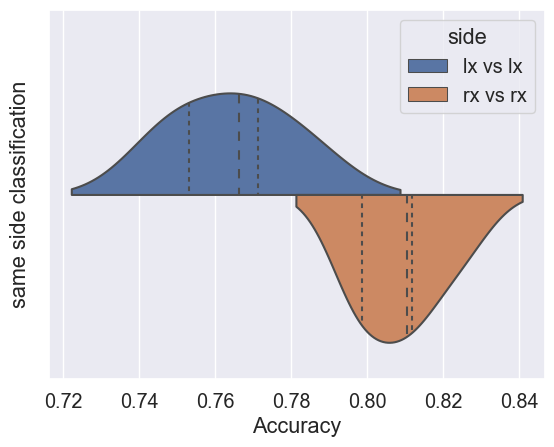

In [18]:
from seaborn import violinplot

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile')
# ax.set_ylim(0.5, 1.0)

#### LX vs RX

In [19]:
clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
models_lxrx, _ = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)

100%|██████████| 29/29 [00:01<00:00, 20.20it/s]


In [17]:
models_lxrx.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.77,0.77,0.77,0.77,0.12
SVC,0.76,0.76,0.76,0.76,0.03
KNeighborsClassifier,0.76,0.76,0.76,0.75,0.01
ExtraTreesClassifier,0.75,0.75,0.75,0.75,0.08
AdaBoostClassifier,0.74,0.74,0.74,0.74,0.06
LGBMClassifier,0.73,0.73,0.73,0.73,0.38
LabelSpreading,0.73,0.73,0.73,0.73,0.02
NuSVC,0.73,0.73,0.73,0.73,0.03
LabelPropagation,0.73,0.73,0.73,0.73,0.02


#### RX vs LX

In [18]:
clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
models_rxrx, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)

100%|██████████| 29/29 [00:01<00:00, 27.39it/s]


In [19]:
models_rxrx.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.71,0.71,0.71,0.71,0.01
RandomForestClassifier,0.71,0.71,0.71,0.71,0.12
BaggingClassifier,0.71,0.71,0.71,0.71,0.03
LabelPropagation,0.71,0.71,0.71,0.71,0.03
LabelSpreading,0.71,0.71,0.71,0.71,0.02
ExtraTreesClassifier,0.70,0.70,0.70,0.70,0.08
LGBMClassifier,0.70,0.70,0.70,0.70,0.38
XGBClassifier,0.70,0.70,0.70,0.70,0.05
NuSVC,0.70,0.70,0.70,0.70,0.02


## 5-fold CV - different seeds

### LX vs LX

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [20]:
averaged_results_cv_multi_lxlx, all_results_cv_multi_lxlx = run_cross_validation_prediction(
    x=features_left,
    y=labels_left,
    groups=groups_left,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=10,
    n_seeds_to_test_folds=10,
)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.38it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.24it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.23it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.62it/s]

100%|██████████| 29/29 [00:00<00:00, 46.54it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.70it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.61it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.51it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.51it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.23it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.24it/s]


In [21]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_multi_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.7653            0.7652  0.7652   0.7648   
RandomForestClassifier          0.7592            0.7591  0.7591   0.7587   
LGBMClassifier                  0.7504            0.7504  0.7504   0.7500   
XGBClassifier                   0.7410            0.7410  0.7410   0.7405   
BaggingClassifier               0.7401            0.7401  0.7401   0.7395   
AdaBoostClassifier              0.7192            0.7192  0.7192   0.7185   
LabelSpreading                  0.7185            0.7185  0.7185   0.7179   
LabelPropagation                0.7178            0.7178  0.7178   0.7173   
KNeighborsClassifier            0.7177            0.7177  0.7177   0.7173   
NuSVC                           0.7101            0.7101  0.7101   0.7093   
DecisionTreeClassifier          0.7074            0.7074  0.7074   0.7069   
SVC                             0.6958            0.6958  0.6958   0.6953   
ExtraTreeClassifier             0.6867            0.6867  0.6867   0.6862   
LogisticRegression              0.6376            0.6376  0.6376   0.6369   
CalibratedClassifierCV          0.6373            0.6373  0.6373   0.6367   
RidgeClassifierCV               0.6345            0.6344  0.6344   0.6338   
LinearSVC                       0.6324            0.6324  0.6324   0.6317   
RidgeClassifier                 0.6299            0.6299  0.6299   0.6293   
LinearDiscriminantAnalysis      0.6271            0.6270  0.6270   0.6264   
NearestCentroid                 0.6253            0.6253  0.6253   0.6246   
BernoulliNB                     0.6216            0.6216  0.6216   0.6198   
SGDClassifier                   0.5810            0.5810  0.5810   0.5656   
Perceptron                      0.5598            0.5598  0.5598   0.5439   
PassiveAggressiveClassifier     0.5592            0.5591  0.5591   0.5314   
GaussianNB                      0.5463            0.5463  0.5463   0.4666   
QuadraticDiscriminantAnalysis   0.5456            0.5456  0.5456   0.4860   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0714         0.0014            0.0014   
RandomForestClassifier            0.1058         0.0013            0.0013   
LGBMClassifier                    0.0331         0.0012            0.0012   
XGBClassifier                     0.0714         0.0013            0.0013   
BaggingClassifier                 0.0257         0.0015            0.0015   
AdaBoostClassifier                0.0521         0.0018            0.0018   
LabelSpreading                    0.0095         0.0014            0.0014   
LabelPropagation                  0.0074         0.0014            0.0014   
KNeighborsClassifier              0.0057         0.0015            0.0015   
NuSVC                             0.0160         0.0012            0.0012   
DecisionTreeClassifier            0.0063         0.0017            0.0017   
SVC                               0.0126         0.0016            0.0016   
ExtraTreeClassifier               0.0040         0.0018            0.0018   
LogisticRegression                0.0061         0.0020            0.0020   
CalibratedClassifierCV            0.1100         0.0021            0.0021   
RidgeClassifierCV                 0.0045         0.0019            0.0019   
LinearSVC                         0.0293         0.0019            0.0019   
RidgeClassifier                   0.0043         0.0019            0.0019   
LinearDiscriminantAnalysis        0.0041         0.0019            0.0019   
NearestCentroid           

### RX vs RX

In [22]:
averaged_results_cv_multi_rxrx, all_results_cv_multi_rxrx = run_cross_validation_prediction(
    x=features_right,
    y=labels_right,
    groups=groups_right,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=10,
    n_seeds_to_test_folds=10,
)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.92it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.62it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.59it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.15it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.53it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.75it/s]

100%|██████████| 29/29 [00:00<00:00, 47.56it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.36it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.06it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.78it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.78it/s]

100%|██████████| 29/29 [00:00<00:00, 47.81it/s]


In [23]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_multi_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.8144            0.8144  0.8144   0.8141   
RandomForestClassifier          0.8134            0.8134  0.8134   0.8132   
LGBMClassifier                  0.8083            0.8083  0.8083   0.8081   
XGBClassifier                   0.8064            0.8064  0.8064   0.8062   
BaggingClassifier               0.7993            0.7993  0.7993   0.7989   
KNeighborsClassifier            0.7829            0.7829  0.7829   0.7827   
AdaBoostClassifier              0.7738            0.7738  0.7738   0.7735   
NuSVC                           0.7703            0.7703  0.7703   0.7699   
SVC                             0.7663            0.7663  0.7663   0.7659   
DecisionTreeClassifier          0.7624            0.7624  0.7624   0.7620   
LabelSpreading                  0.7592            0.7593  0.7593   0.7587   
LabelPropagation                0.7569            0.7569  0.7569   0.7564   
ExtraTreeClassifier             0.7427            0.7427  0.7427   0.7423   
CalibratedClassifierCV          0.7047            0.7047  0.7047   0.7040   
NearestCentroid                 0.7010            0.7010  0.7010   0.7004   
BernoulliNB                     0.6989            0.6989  0.6989   0.6982   
LinearDiscriminantAnalysis      0.6966            0.6966  0.6966   0.6961   
GaussianNB                      0.6961            0.6960  0.6960   0.6934   
LinearSVC                       0.6915            0.6914  0.6914   0.6908   
RidgeClassifierCV               0.6914            0.6914  0.6914   0.6908   
LogisticRegression              0.6914            0.6914  0.6914   0.6908   
RidgeClassifier                 0.6907            0.6907  0.6907   0.6901   
SGDClassifier                   0.6372            0.6372  0.6372   0.6294   
Perceptron                      0.6114            0.6114  0.6114   0.6019   
PassiveAggressiveClassifier     0.6103            0.6103  0.6103   0.5937   
QuadraticDiscriminantAnalysis   0.6094            0.6094  0.6094   0.5855   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0681         0.0012            0.0012   
RandomForestClassifier            0.1022         0.0014            0.0014   
LGBMClassifier                    0.0342         0.0014            0.0014   
XGBClassifier                     0.0682         0.0013            0.0013   
BaggingClassifier                 0.0248         0.0014            0.0014   
KNeighborsClassifier              0.0057         0.0015            0.0015   
AdaBoostClassifier                0.0522         0.0013            0.0013   
NuSVC                             0.0123         0.0017            0.0017   
SVC                               0.0109         0.0016            0.0016   
DecisionTreeClassifier            0.0064         0.0015            0.0015   
LabelSpreading                    0.0097         0.0015            0.0015   
LabelPropagation                  0.0074         0.0016            0.0016   
ExtraTreeClassifier               0.0040         0.0017            0.0017   
CalibratedClassifierCV            0.1114         0.0017            0.0017   
NearestCentroid                   0.0039         0.0017            0.0017   
BernoulliNB                       0.0039         0.0017            0.0017   
LinearDiscriminantAnalysis        0.0041         0.0016            0.0016   
GaussianNB                        0.0038         0.0021            0.0021   
LinearSVC                         0.0293         0.0016            0.0016   
RidgeClassifierCV         

#### Visualizing results

In [26]:
selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_cv_multi_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_cv_multi_lxlx
    for single_result in seed_res
]

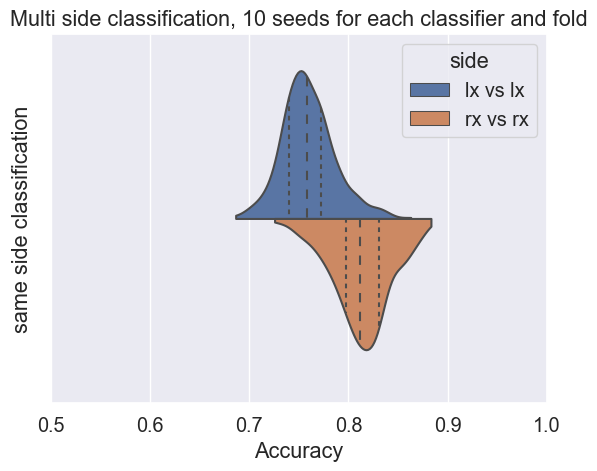

In [32]:
import matplotlib.pyplot as plt
from seaborn import violinplot

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile', cut=0)
plt.title("Multi side classification, 10 seeds for each classifier and fold")
ax.set_xlim(0.5, 1.0)
plt.show()

## LOSO

In [14]:
model_selected: str = "RandomForestClassifier"
metrics_selected: str = 'Accuracy'
n_seeds_to_test_classifiers: int = 30

### Test with different seeds (LX vs LX)

In [24]:
averaged_results_loso_lxlx, all_results_loso_lxlx = run_same_side_classifications(
    features_left_high,
    labels_left_high,
    groups_left_high,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
    n_jobs=6,
)


Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 98.51it/s]

100%|██████████| 29/29 [00:00<00:00, 101.62it/s]


In [25]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.5915            0.5915  0.5915   0.5530   
LGBMClassifier                  0.5885            0.5885  0.5885   0.5662   
XGBClassifier                   0.5885            0.5885  0.5885   0.5663   
GaussianNB                      0.5781            0.5781  0.5781   0.5108   
RandomForestClassifier          0.5550            0.5550  0.5550   0.5218   
QuadraticDiscriminantAnalysis   0.5521            0.5521  0.5521   0.5087   
BaggingClassifier               0.5373            0.5373  0.5373   0.5161   
DecisionTreeClassifier          0.5095            0.5095  0.5095   0.4954   
ExtraTreeClassifier             0.5076            0.5076  0.5076   0.4815   
PassiveAggressiveClassifier     0.5009            0.5009  0.5009   0.4296   
Perceptron                      0.5007            0.5007  0.5007   0.4503   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   
NuSVC                           0.4948            0.4948  0.4948   0.4837   
AdaBoostClassifier              0.4856            0.4856  0.4856   0.4731   
SGDClassifier                   0.4797            0.4797  0.4797   0.4226   
LinearSVC                       0.4062            0.4062  0.4062   0.3850   
RidgeClassifierCV               0.4062            0.4062  0.4063   0.3798   
LabelPropagation                0.4010            0.4010  0.4010   0.3750   
KNeighborsClassifier            0.4010            0.4010  0.4010   0.3563   
LogisticRegression              0.3906            0.3906  0.3906   0.3701   
LabelSpreading                  0.3906            0.3906  0.3906   0.3654   
LinearDiscriminantAnalysis      0.3906            0.3906  0.3906   0.3606   
RidgeClassifier                 0.3802            0.3802  0.3802   0.3566   
BernoulliNB                     0.3750            0.3750  0.3750   0.3522   
CalibratedClassifierCV          0.3594            0.3594  0.3594   0.3241   
SVC                             0.2865            0.2865  0.2865   0.2548   
NearestCentroid                 0.2708            0.2708  0.2708   0.2175   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0494         0.0208            0.0208   
LGBMClassifier                    0.0098         0.0217            0.0217   
XGBClassifier                     0.0188         0.0211            0.0211   
GaussianNB                        0.0033         0.0084            0.0084   
RandomForestClassifier            0.0638         0.0186            0.0186   
QuadraticDiscriminantAnalysis     0.0032         0.0160            0.0160   
BaggingClassifier                 0.0123         0.0190            0.0190   
DecisionTreeClassifier            0.0037         0.0200            0.0200   
ExtraTreeClassifier               0.0032         0.0154            0.0154   
PassiveAggressiveClassifier       0.0035         0.0195            0.0195   
Perceptron                        0.0034         0.0227            0.0227   
DummyClassifier                   0.0030         0.0000            0.0000   
NuSVC                             0.0050         0.0215            0.0215   
AdaBoostClassifier                0.0348         0.0216            0.0216   
SGDClassifier                     0.0036         0.0208            0.0208   
LinearSVC                         0.0073         0.0204            0.0204   
RidgeClassifierCV                 0.0038         0.0228            0.0228   
LabelPropagation                  0.0035         0.0172            0.0172   
KNeighborsClassifier              0.0035         0.0154            0.0154   
LogisticRegression        

### Test with different seeds (RX vs RX)

In [26]:
averaged_results_loso_rxrx, all_results_loso_rxrx = run_same_side_classifications(
    features_right_high,
    labels_right_high,
    groups_right_high,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
)


Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 98.21it/s]


In [18]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.8212            0.8212  0.8212   0.8108   
NuSVC                           0.8108            0.8108  0.8108   0.7956   
RandomForestClassifier          0.8047            0.8047  0.8047   0.7939   
AdaBoostClassifier              0.7997            0.7997  0.7997   0.7870   
ExtraTreesClassifier            0.7938            0.7938  0.7938   0.7839   
XGBClassifier                   0.7934            0.7934  0.7934   0.7837   
BaggingClassifier               0.7917            0.7917  0.7917   0.7813   
LGBMClassifier                  0.7865            0.7865  0.7865   0.7769   
CalibratedClassifierCV          0.7847            0.7847  0.7847   0.7642   
KNeighborsClassifier            0.7847            0.7847  0.7847   0.7750   
LabelSpreading                  0.7812            0.7812  0.7812   0.7717   
LabelPropagation                0.7778            0.7778  0.7778   0.7684   
RidgeClassifierCV               0.7743            0.7743  0.7743   0.7565   
LinearSVC                       0.7726            0.7726  0.7726   0.7597   
NearestCentroid                 0.7708            0.7708  0.7708   0.7535   
RidgeClassifier                 0.7691            0.7691  0.7691   0.7549   
BernoulliNB                     0.7691            0.7691  0.7691   0.7484   
LogisticRegression              0.7604            0.7604  0.7604   0.7471   
LinearDiscriminantAnalysis      0.7569            0.7569  0.7569   0.7423   
DecisionTreeClassifier          0.7394            0.7394  0.7394   0.7284   
GaussianNB                      0.7326            0.7326  0.7326   0.7249   
ExtraTreeClassifier             0.7274            0.7274  0.7274   0.7171   
SGDClassifier                   0.6689            0.6689  0.6689   0.6298   
QuadraticDiscriminantAnalysis   0.6406            0.6406  0.6406   0.5881   
PassiveAggressiveClassifier     0.6374            0.6374  0.6374   0.5839   
Perceptron                      0.6296            0.6296  0.6296   0.5845   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0085         0.0185            0.0185   
NuSVC                             0.0112         0.0190            0.0190   
RandomForestClassifier            0.1148         0.0160            0.0160   
AdaBoostClassifier                0.0598         0.0150            0.0150   
ExtraTreesClassifier              0.0766         0.0159            0.0159   
XGBClassifier                     0.0672         0.0156            0.0156   
BaggingClassifier                 0.0262         0.0158            0.0158   
LGBMClassifier                    0.0338         0.0168            0.0168   
CalibratedClassifierCV            0.1103         0.0228            0.0228   
KNeighborsClassifier              0.0046         0.0178            0.0178   
LabelSpreading                    0.0089         0.0173            0.0173   
LabelPropagation                  0.0071         0.0173            0.0173   
RidgeClassifierCV                 0.0049         0.0233            0.0233   
LinearSVC                         0.0306         0.0246            0.0246   
NearestCentroid                   0.0045         0.0249            0.0249   
RidgeClassifier                   0.0049         0.0246            0.0246   
BernoulliNB                       0.0042         0.0248            0.0248   
LogisticRegression                0.0072         0.0245            0.0245   
LinearDiscriminantAnalysis        0.0047         0.0242            0.0242   
DecisionTreeClassifier    

In [27]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
QuadraticDiscriminantAnalysis   0.5469            0.5469  0.5469   0.4883   
NearestCentroid                 0.5208            0.5208  0.5208   0.4839   
NuSVC                           0.5052            0.5052  0.5052   0.4814   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   
SGDClassifier                   0.4750            0.4750  0.4750   0.4061   
RidgeClassifierCV               0.4740            0.4740  0.4740   0.4567   
GaussianNB                      0.4688            0.4688  0.4688   0.4149   
Perceptron                      0.4667            0.4667  0.4667   0.4010   
RidgeClassifier                 0.4635            0.4635  0.4635   0.4467   
KNeighborsClassifier            0.4635            0.4635  0.4635   0.4433   
ExtraTreesClassifier            0.4625            0.4625  0.4625   0.4518   
ExtraTreeClassifier             0.4620            0.4620  0.4620   0.4498   
PassiveAggressiveClassifier     0.4585            0.4585  0.4585   0.3817   
LogisticRegression              0.4583            0.4583  0.4583   0.4380   
BernoulliNB                     0.4583            0.4583  0.4583   0.4467   
XGBClassifier                   0.4583            0.4583  0.4583   0.4352   
DecisionTreeClassifier          0.4493            0.4493  0.4493   0.4252   
LinearSVC                       0.4479            0.4479  0.4479   0.4292   
RandomForestClassifier          0.4434            0.4434  0.4434   0.4316   
LabelSpreading                  0.4427            0.4427  0.4427   0.4248   
LGBMClassifier                  0.4427            0.4427  0.4427   0.4207   
LabelPropagation                0.4427            0.4427  0.4427   0.4248   
LinearDiscriminantAnalysis      0.4323            0.4323  0.4323   0.4024   
BaggingClassifier               0.4255            0.4255  0.4255   0.4124   
AdaBoostClassifier              0.3234            0.3234  0.3234   0.3134   
CalibratedClassifierCV          0.3021            0.3021  0.3021   0.2505   
SVC                             0.2031            0.2031  0.2031   0.1670   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
QuadraticDiscriminantAnalysis     0.0032         0.0121            0.0121   
NearestCentroid                   0.0038         0.0274            0.0274   
NuSVC                             0.0052         0.0134            0.0134   
DummyClassifier                   0.0032         0.0000            0.0000   
SGDClassifier                     0.0038         0.0187            0.0187   
RidgeClassifierCV                 0.0039         0.0226            0.0226   
GaussianNB                        0.0037         0.0177            0.0177   
Perceptron                        0.0035         0.0183            0.0183   
RidgeClassifier                   0.0039         0.0218            0.0218   
KNeighborsClassifier              0.0038         0.0121            0.0121   
ExtraTreesClassifier              0.0511         0.0132            0.0132   
ExtraTreeClassifier               0.0034         0.0121            0.0121   
PassiveAggressiveClassifier       0.0036         0.0184            0.0184   
LogisticRegression                0.0043         0.0228            0.0228   
BernoulliNB                       0.0034         0.0169            0.0169   
XGBClassifier                     0.0204         0.0134            0.0134   
DecisionTreeClassifier            0.0038         0.0146            0.0146   
LinearSVC                         0.0067         0.0206            0.0206   
RandomForestClassifier            0.0649         0.0158            0.0158   
LabelSpreading            

### Visualizing results (same side)

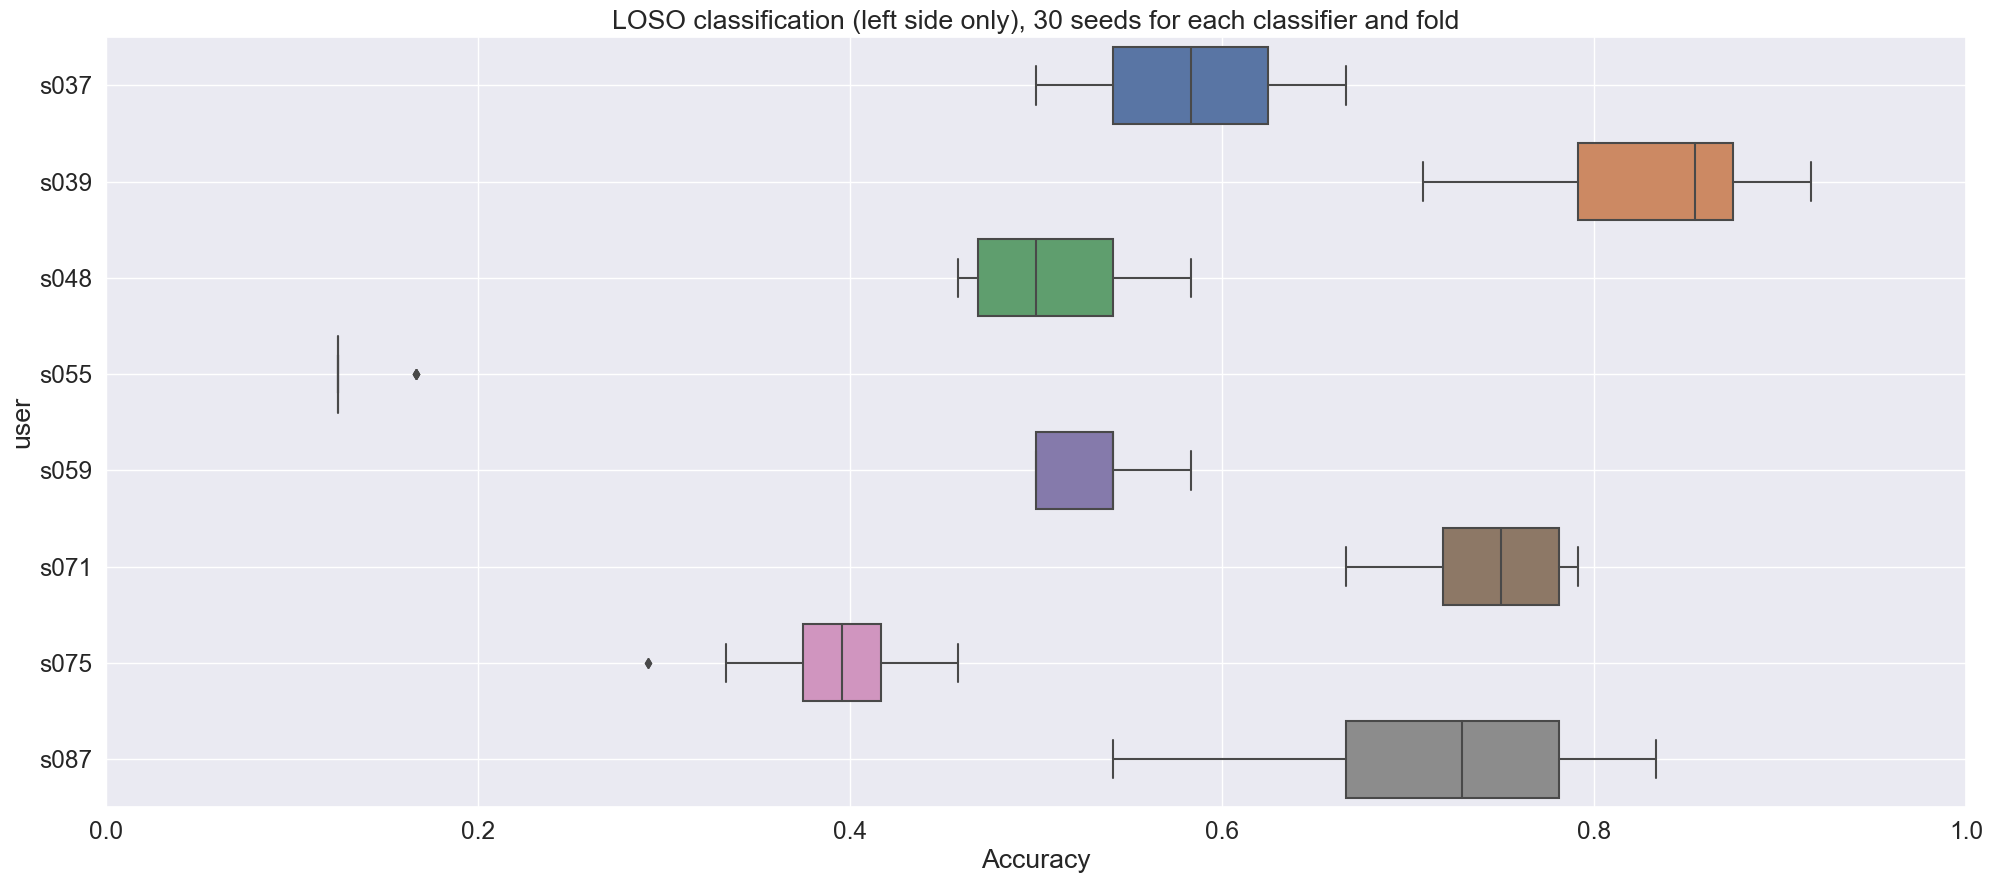

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns


selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx", single_result.columns.name)
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 10))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_lxlx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user")
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.title(f"LOSO classification (left side only), {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0)
plt.show()


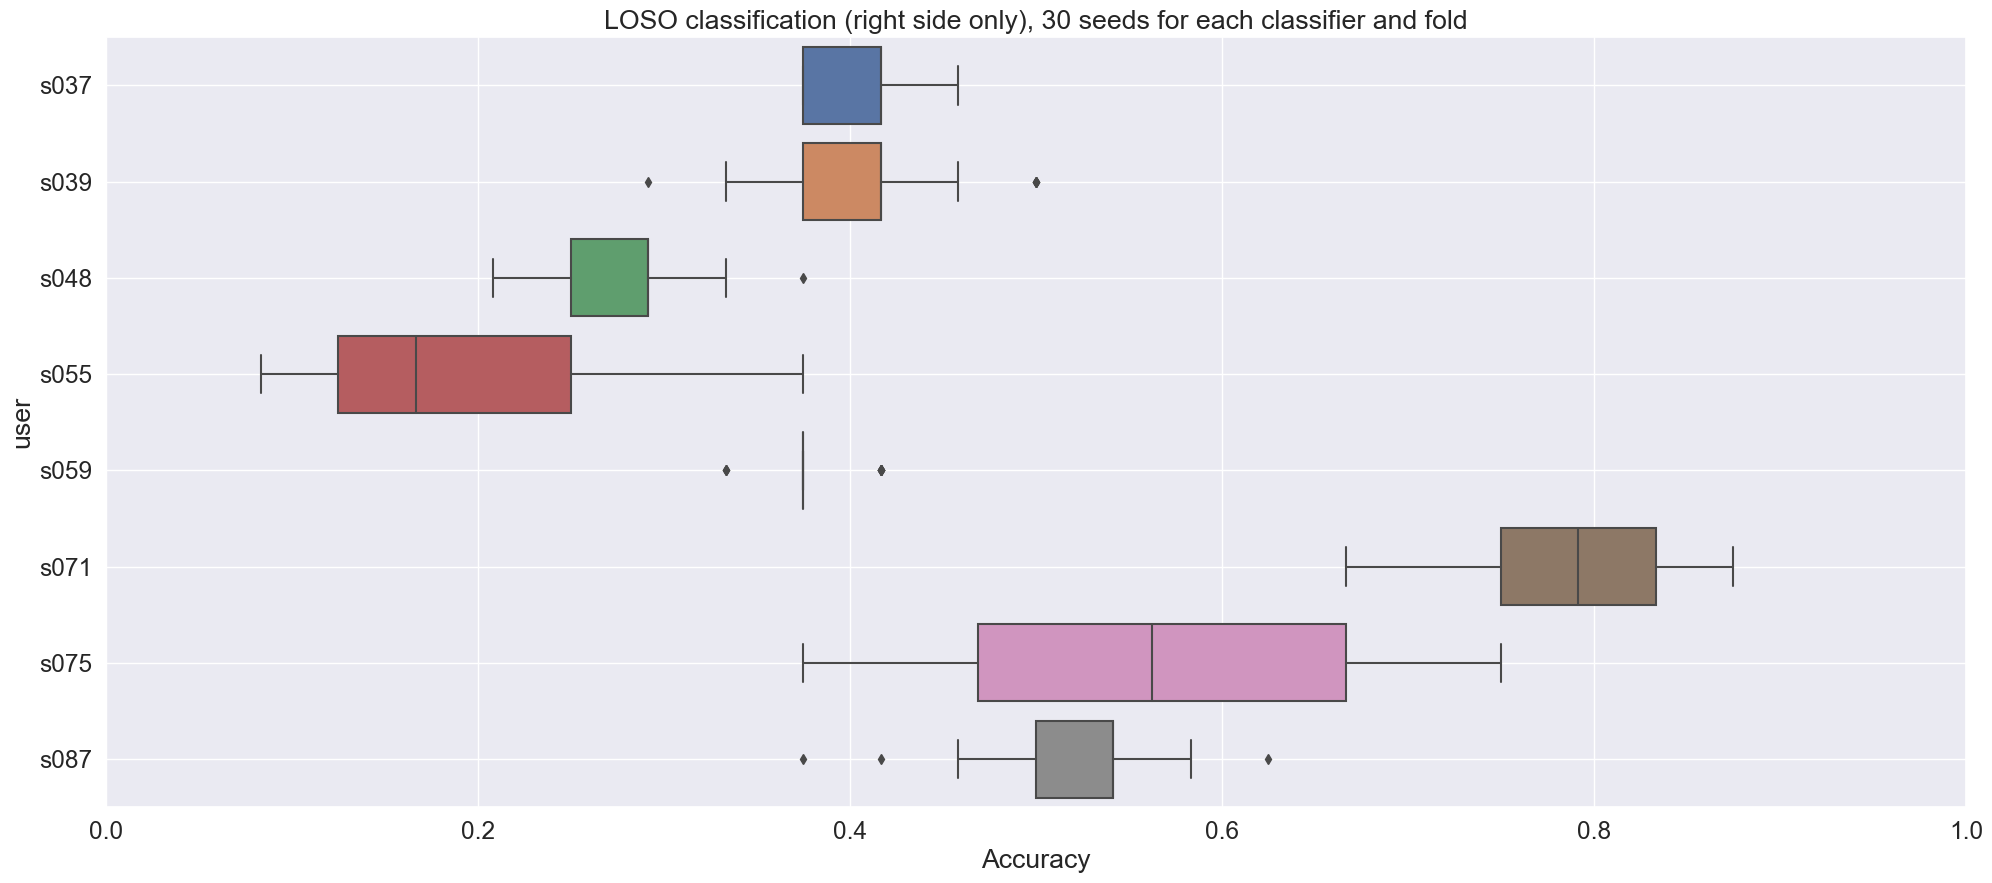

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx", single_result.columns.name)
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

plt.figure(figsize=(24, 10))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_rxrx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user")
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.title(f"LOSO classification (right side only), {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0)
plt.show()


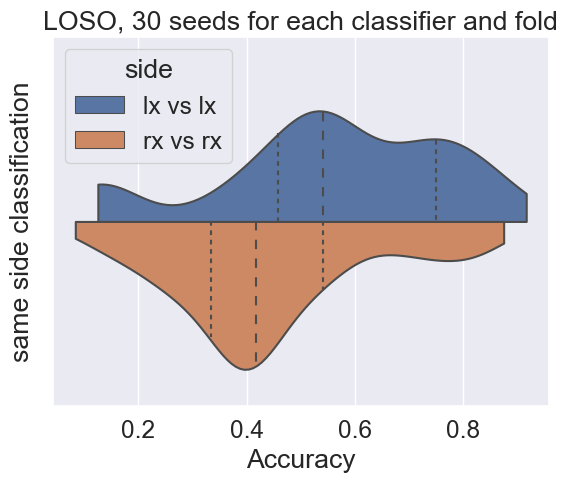

In [30]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile', cut=0)
plt.title(f"LOSO, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
# ax.set_xlim(0.5, 1.0)
plt.show()

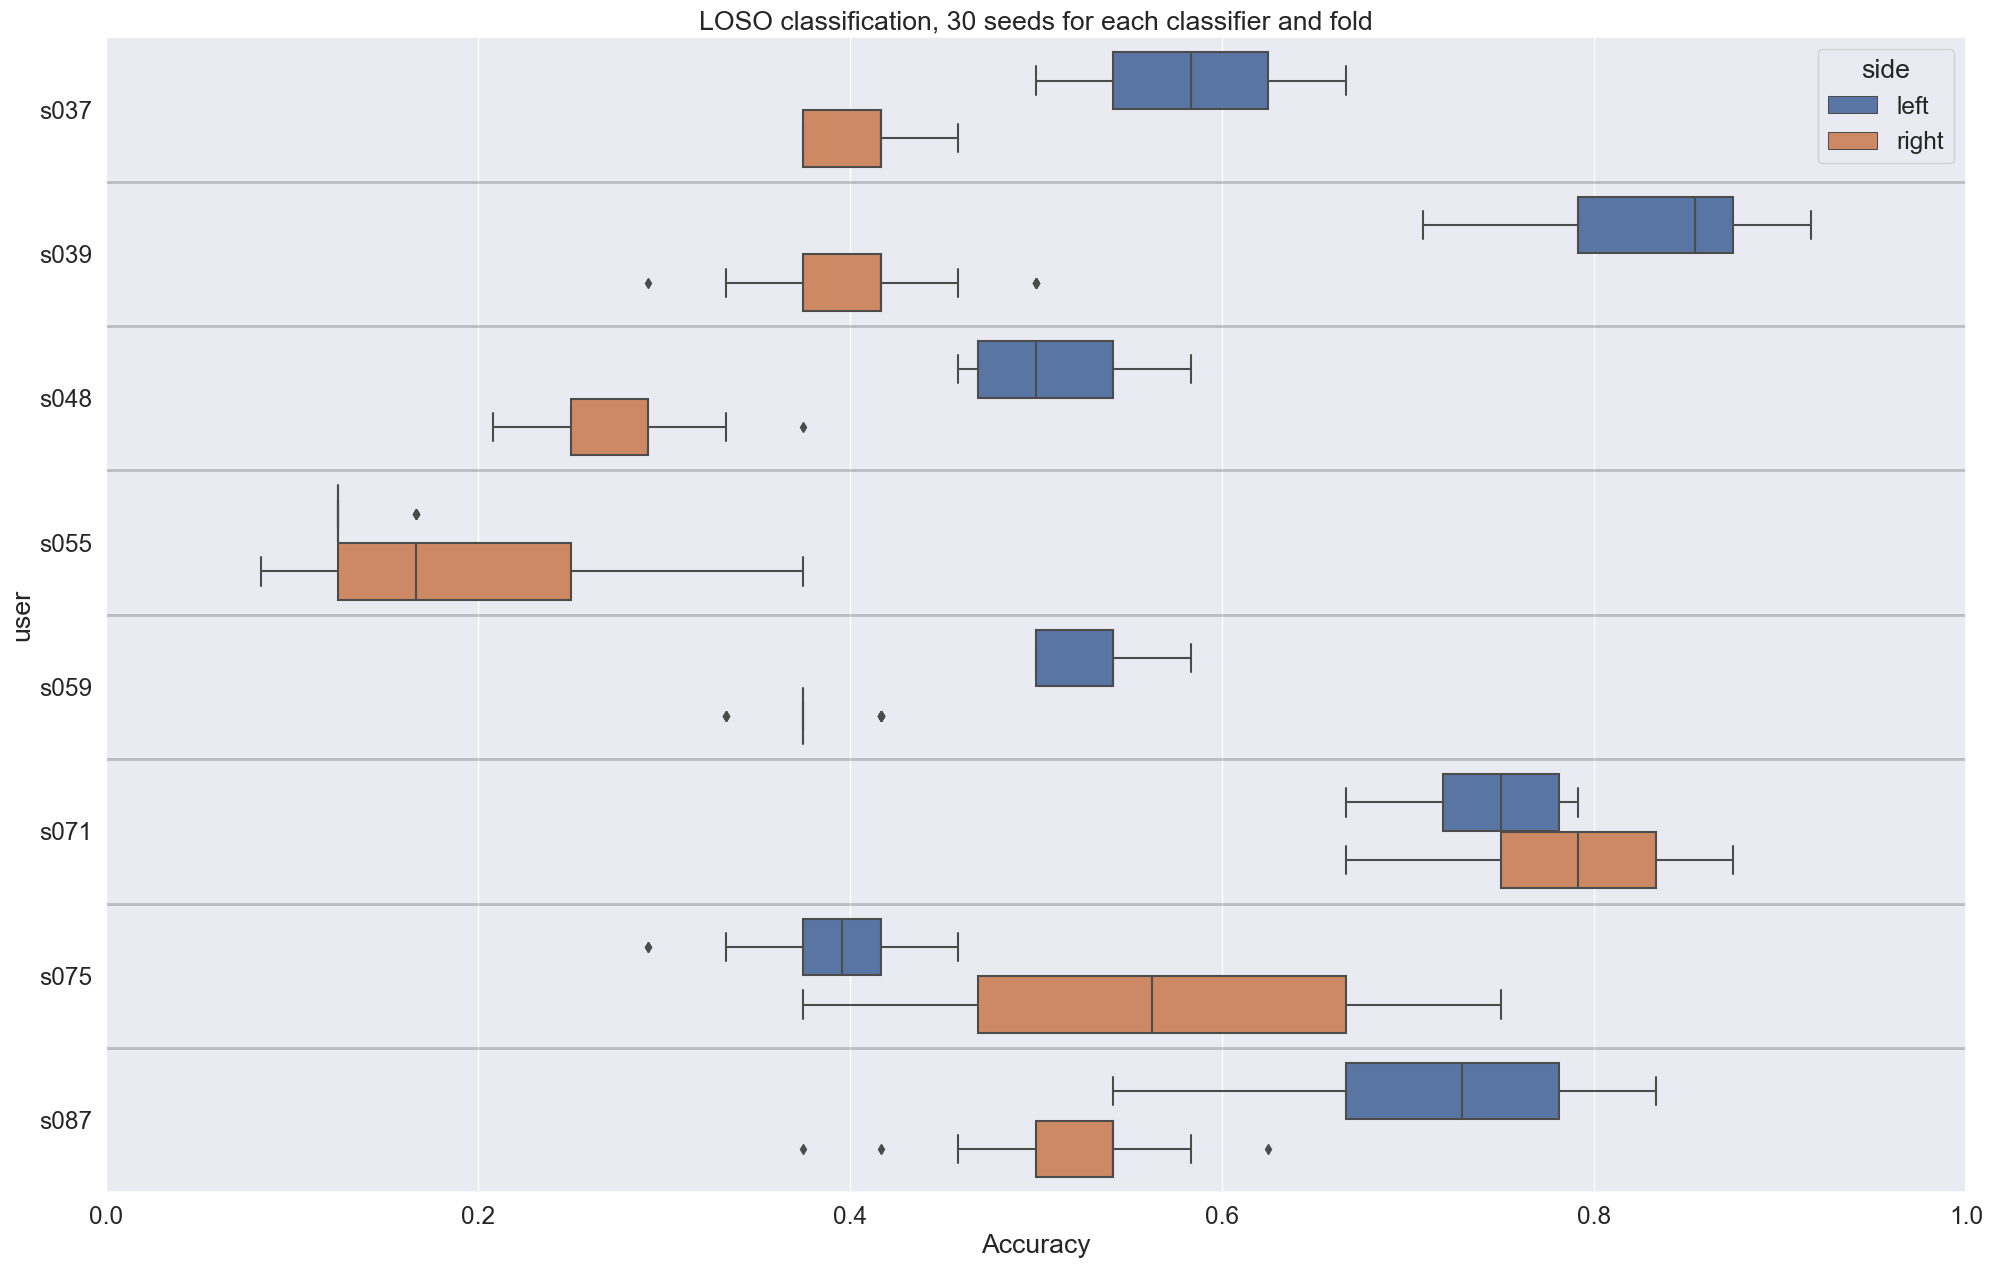

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", single_result.columns.name)
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", single_result.columns.name)
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 15))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_rxrx, *selected_results_lxlx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user", hue='side')
ax.xaxis.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=2, color='black', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='-', linewidth=13, color='orange', alpha=0.3)
plt.title(f"LOSO classification, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0) 
plt.show()


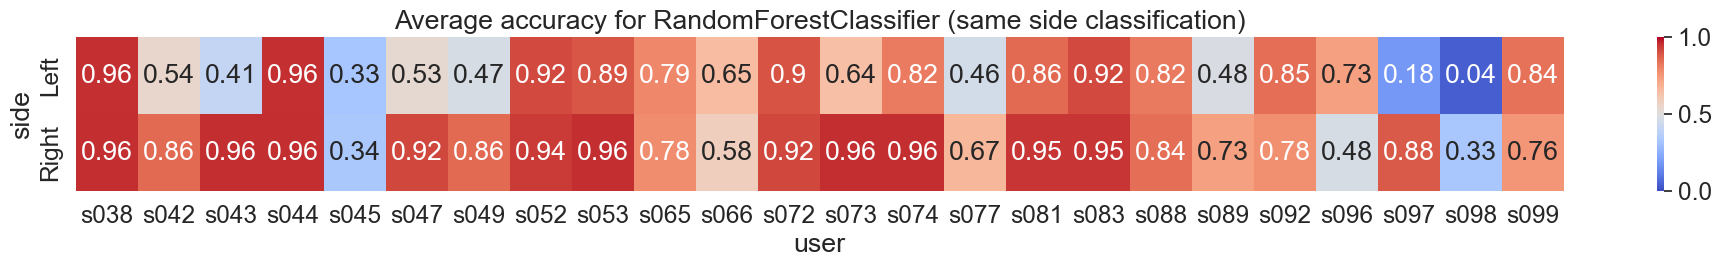

In [23]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (same side classification)")
plt.show()

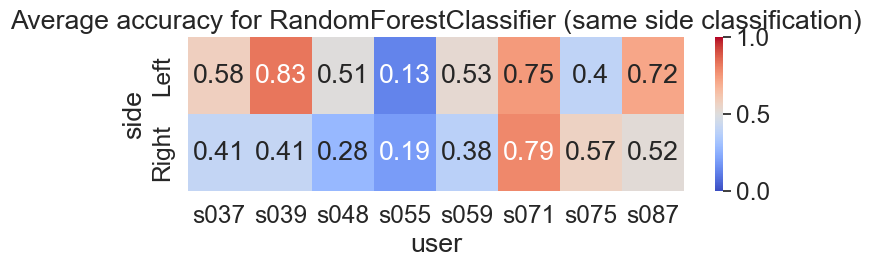

In [32]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (same side classification)")
plt.show()

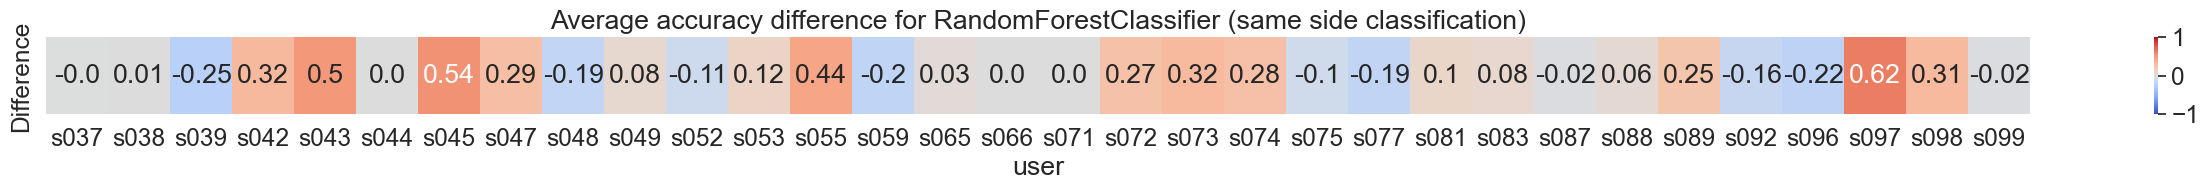

In [29]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
data_to_plot3 = data_to_plot2.iloc[1,:] - data_to_plot2.iloc[0,:]
data_to_plot3 = DataFrame(data_to_plot3, columns=['Difference']).T

plt.figure(figsize=(len(data_to_plot3.columns),1))
ax = sns.heatmap(data_to_plot3, 
            yticklabels=['Difference'],
            cmap='coolwarm', 
            annot=data_to_plot3.round(decimals=2).values,
            vmin=-1, vmax=1,
            center=0,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy difference for {model_selected} (same side classification)")
plt.show()

Here is it noted that the distribution of labels across each individual is the same as the total, since the duration of the experiment was them same. It is also noted that a per-user undersampling is performed.

In [25]:
# from pandas import Series 

# selected_user: str = "s077"
# left_data_mask: ndarray = groups_left == selected_user
# current_labels_left = labels_left[left_data_mask]
# right_data_mask: ndarray = groups_right == selected_user
# current_labels_right = labels_right[right_data_mask]

# counts = {
#     "left": Series(current_labels_left).value_counts(),
#     "right": Series(current_labels_right).value_counts(),
# }
# counts = DataFrame(counts).unstack().reset_index()
# counts.columns = ["side", "label", "count"]
# counts["label"] = counts["label"].map({0: "relaxation", 1: "cognitive load"})
# plot_binary_labels(
#     counts=counts,
#     title=f"Distribution of labels, USILaughs dataset, user {selected_user}",
#     dataset_name=f"usilaughs_{selected_user}",
#     output_folder="../visualizations/"
# )


### Test with different seeds (LX vs RX)

In [63]:
averaged_results_loso_lxrx, all_results_loso_lxrx = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.30it/s]


In [65]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_lxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7435            0.7435  0.7435   0.7223   
KNeighborsClassifier            0.7435            0.7435  0.7435   0.7321   
NuSVC                           0.7174            0.7174  0.7174   0.6935   
ExtraTreesClassifier            0.7155            0.7155  0.7155   0.7030   
RandomForestClassifier          0.7127            0.7127  0.7127   0.6951   
LabelSpreading                  0.7057            0.7057  0.7057   0.6952   
LabelPropagation                0.7031            0.7031  0.7031   0.6933   
LinearSVC                       0.6984            0.6984  0.6984   0.6819   
RidgeClassifier                 0.6966            0.6966  0.6966   0.6802   
LinearDiscriminantAnalysis      0.6953            0.6953  0.6953   0.6789   
AdaBoostClassifier              0.6952            0.6952  0.6952   0.6777   
LogisticRegression              0.6940            0.6940  0.6940   0.6776   
RidgeClassifierCV               0.6927            0.6927  0.6927   0.6760   
CalibratedClassifierCV          0.6914            0.6914  0.6914   0.6732   
XGBClassifier                   0.6836            0.6836  0.6836   0.6725   
LGBMClassifier                  0.6758            0.6758  0.6758   0.6631   
NearestCentroid                 0.6732            0.6732  0.6732   0.6550   
BaggingClassifier               0.6718            0.6718  0.6718   0.6588   
BernoulliNB                     0.6562            0.6562  0.6562   0.6398   
ExtraTreeClassifier             0.6401            0.6401  0.6401   0.6289   
DecisionTreeClassifier          0.6211            0.6211  0.6211   0.6108   
SGDClassifier                   0.6031            0.6031  0.6031   0.5672   
Perceptron                      0.5705            0.5705  0.5705   0.5311   
PassiveAggressiveClassifier     0.5479            0.5479  0.5479   0.5003   
GaussianNB                      0.5326            0.5326  0.5326   0.4153   
QuadraticDiscriminantAnalysis   0.5208            0.5208  0.5208   0.4167   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0178         0.0167            0.0167   
KNeighborsClassifier              0.0062         0.0146            0.0146   
NuSVC                             0.0246         0.0162            0.0162   
ExtraTreesClassifier              0.0995         0.0154            0.0154   
RandomForestClassifier            0.1487         0.0164            0.0164   
LabelSpreading                    0.0160         0.0145            0.0145   
LabelPropagation                  0.0114         0.0138            0.0138   
LinearSVC                         0.0486         0.0241            0.0241   
RidgeClassifier                   0.0065         0.0248            0.0248   
LinearDiscriminantAnalysis        0.0064         0.0244            0.0244   
AdaBoostClassifier                0.0757         0.0157            0.0157   
LogisticRegression                0.0095         0.0243            0.0243   
RidgeClassifierCV                 0.0066         0.0254            0.0254   
CalibratedClassifierCV            0.1837         0.0237            0.0237   
XGBClassifier                     0.1060         0.0159            0.0159   
LGBMClassifier                    0.0512         0.0162            0.0162   
NearestCentroid                   0.0062         0.0262            0.0262   
BaggingClassifier                 0.0388         0.0156            0.0156   
BernoulliNB                       0.0057         0.0208            0.0208   
ExtraTreeClassifier       

### Test with different seeds (RX vs LX)

In [66]:
averaged_results_loso_rxlx, all_results_loso_rxlx = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.88it/s]


In [67]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_rxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
KNeighborsClassifier            0.7018            0.7018  0.7018   0.6834   
ExtraTreesClassifier            0.6804            0.6804  0.6804   0.6596   
LabelSpreading                  0.6797            0.6797  0.6797   0.6658   
LabelPropagation                0.6784            0.6784  0.6784   0.6647   
RandomForestClassifier          0.6771            0.6771  0.6771   0.6551   
LGBMClassifier                  0.6745            0.6745  0.6745   0.6532   
NuSVC                           0.6693            0.6693  0.6693   0.6397   
SVC                             0.6667            0.6667  0.6667   0.6383   
XGBClassifier                   0.6628            0.6628  0.6628   0.6414   
BaggingClassifier               0.6623            0.6623  0.6623   0.6445   
AdaBoostClassifier              0.6484            0.6484  0.6484   0.6269   
GaussianNB                      0.6419            0.6419  0.6419   0.6137   
ExtraTreeClassifier             0.6372            0.6372  0.6372   0.6230   
CalibratedClassifierCV          0.6328            0.6328  0.6328   0.6120   
DecisionTreeClassifier          0.6316            0.6316  0.6316   0.6151   
LinearSVC                       0.6314            0.6314  0.6314   0.6137   
LogisticRegression              0.6302            0.6302  0.6302   0.6139   
RidgeClassifier                 0.6289            0.6289  0.6289   0.6095   
LinearDiscriminantAnalysis      0.6276            0.6276  0.6276   0.6100   
RidgeClassifierCV               0.6263            0.6263  0.6263   0.6072   
BernoulliNB                     0.6263            0.6263  0.6263   0.6018   
NearestCentroid                 0.6224            0.6224  0.6224   0.5974   
SGDClassifier                   0.5916            0.5916  0.5916   0.5636   
QuadraticDiscriminantAnalysis   0.5859            0.5859  0.5859   0.5211   
Perceptron                      0.5730            0.5730  0.5730   0.5445   
PassiveAggressiveClassifier     0.5677            0.5677  0.5677   0.5335   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
KNeighborsClassifier              0.0060         0.0179            0.0179   
ExtraTreesClassifier              0.0941         0.0213            0.0213   
LabelSpreading                    0.0161         0.0159            0.0159   
LabelPropagation                  0.0113         0.0161            0.0161   
RandomForestClassifier            0.1419         0.0222            0.0222   
LGBMClassifier                    0.0527         0.0207            0.0207   
NuSVC                             0.0183         0.0221            0.0221   
SVC                               0.0151         0.0229            0.0229   
XGBClassifier                     0.1028         0.0208            0.0208   
BaggingClassifier                 0.0376         0.0209            0.0209   
AdaBoostClassifier                0.0742         0.0233            0.0233   
GaussianNB                        0.0057         0.0251            0.0251   
ExtraTreeClassifier               0.0056         0.0179            0.0179   
CalibratedClassifierCV            0.1822         0.0270            0.0270   
DecisionTreeClassifier            0.0095         0.0205            0.0205   
LinearSVC                         0.0480         0.0269            0.0269   
LogisticRegression                0.0089         0.0271            0.0271   
RidgeClassifier                   0.0063         0.0267            0.0267   
LinearDiscriminantAnalysis        0.0062         0.0266            0.0266   
RidgeClassifierCV         

These results suggest that the test set is the one having the greater importance in the performance of "different sides classifier". However, it is unclear if this is due actual lateralization effect, or due to other factors in play, e.g., artefacts.

### Visualizing results (different side)

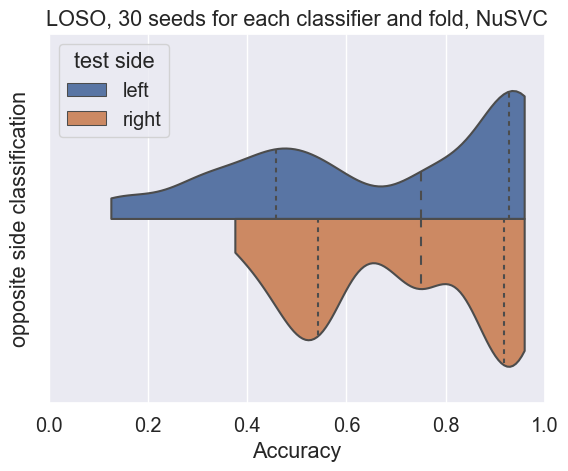

In [68]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right")
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left")
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

extra_col_name: str = 'opposite side classification'
data_to_plot = DataFrame([*selected_results_rxlx, *selected_results_lxrx], columns=[metrics_selected, "test side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='test side', split=True, inner='quartile', cut=0)
plt.title(f"LOSO, {n_seeds_to_test_classifiers} seeds for each classifier and fold, {model_selected}")
ax.set_xlim(0., 1.0)
plt.show()

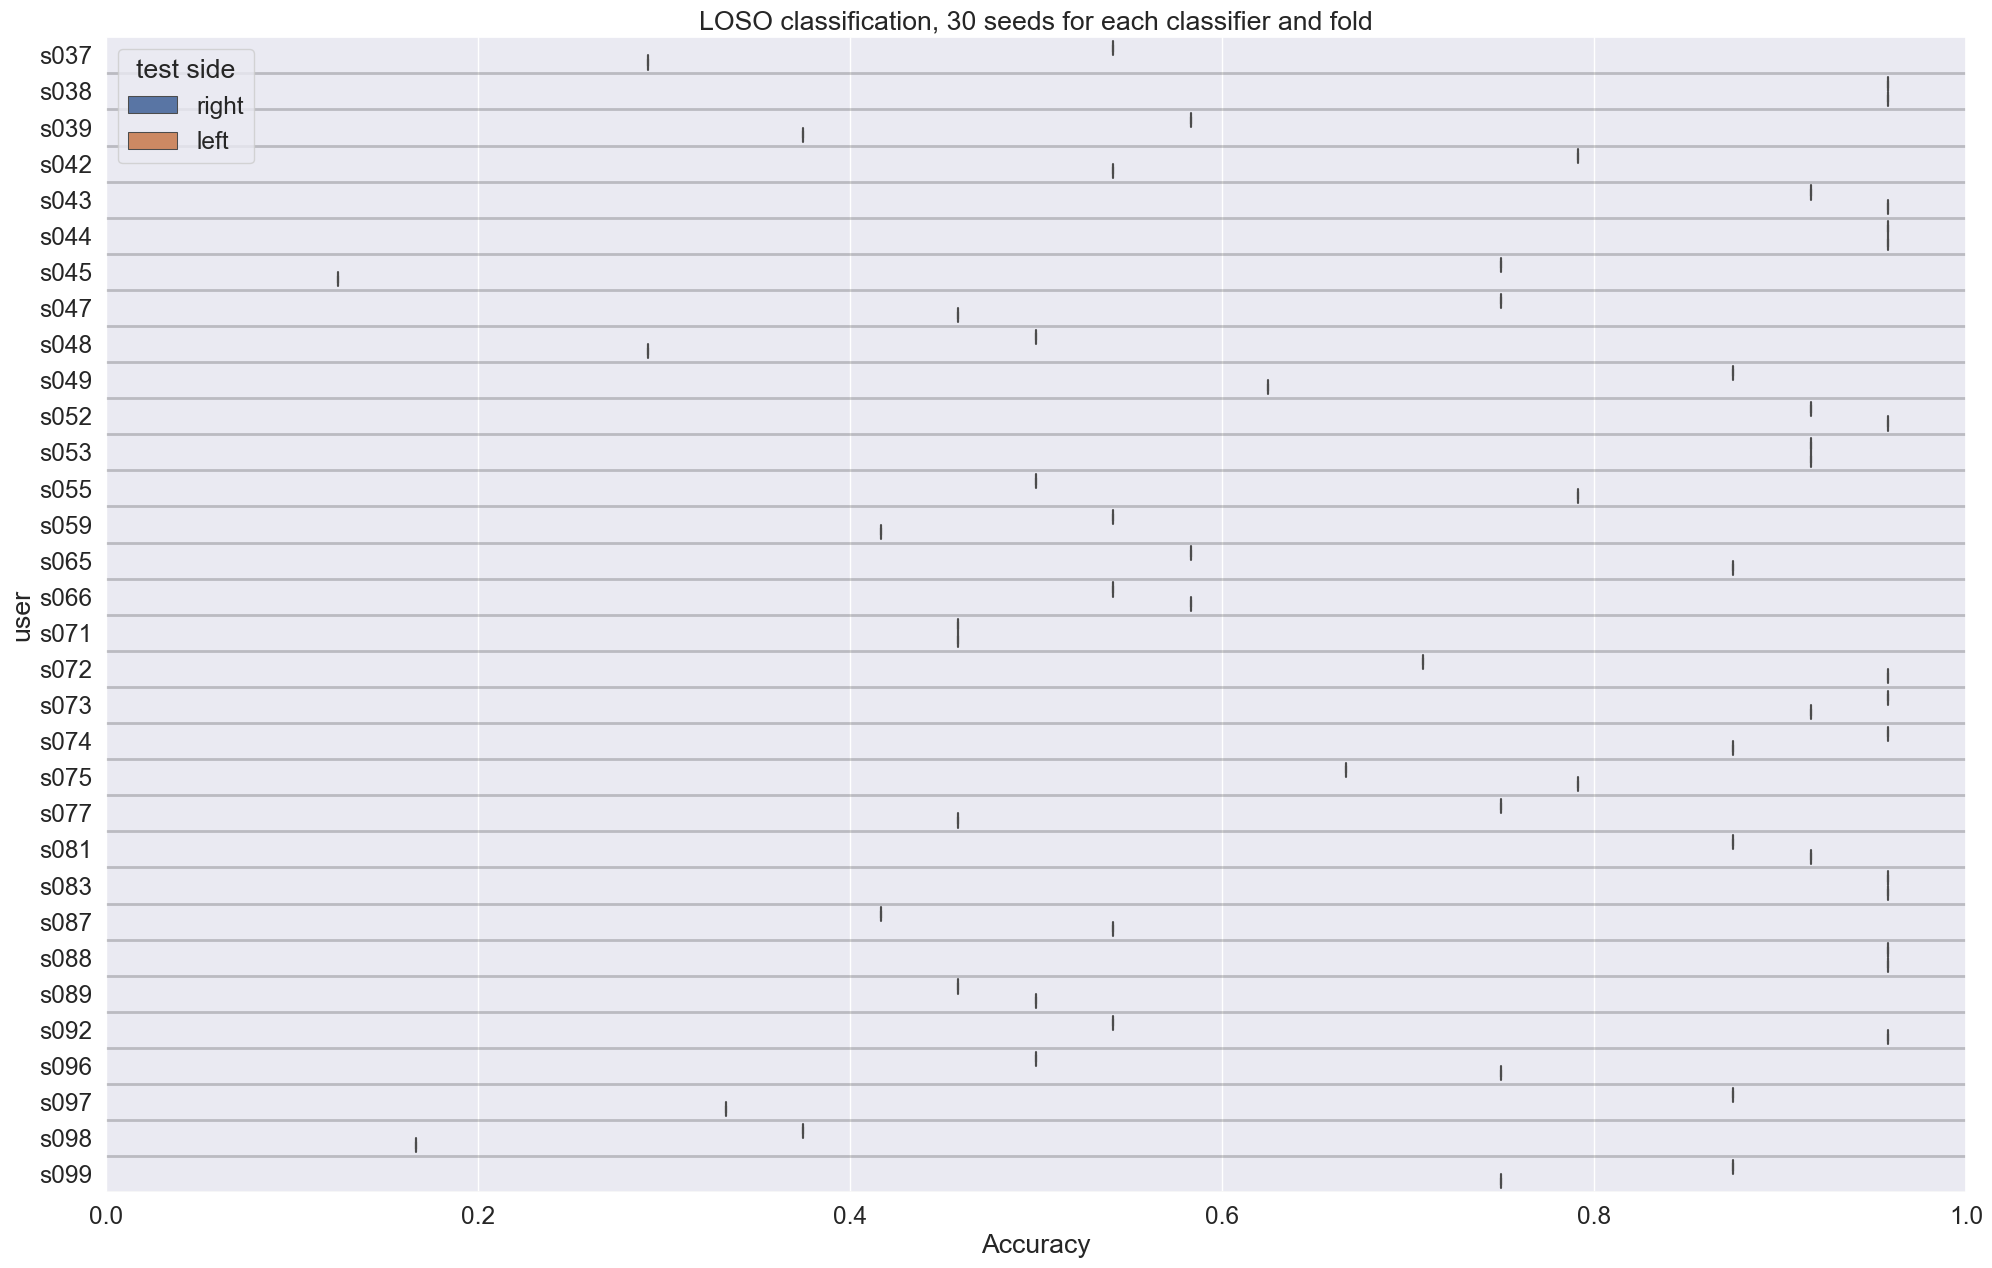

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", single_result.columns.name)
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", single_result.columns.name)
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 15))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_lxrx, *selected_results_rxlx], columns=[metrics_selected, "test side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user", hue='test side')
ax.xaxis.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=2, color='black', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='-', linewidth=13, color='orange', alpha=0.3)
plt.title(f"LOSO classification, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0) 
plt.show()


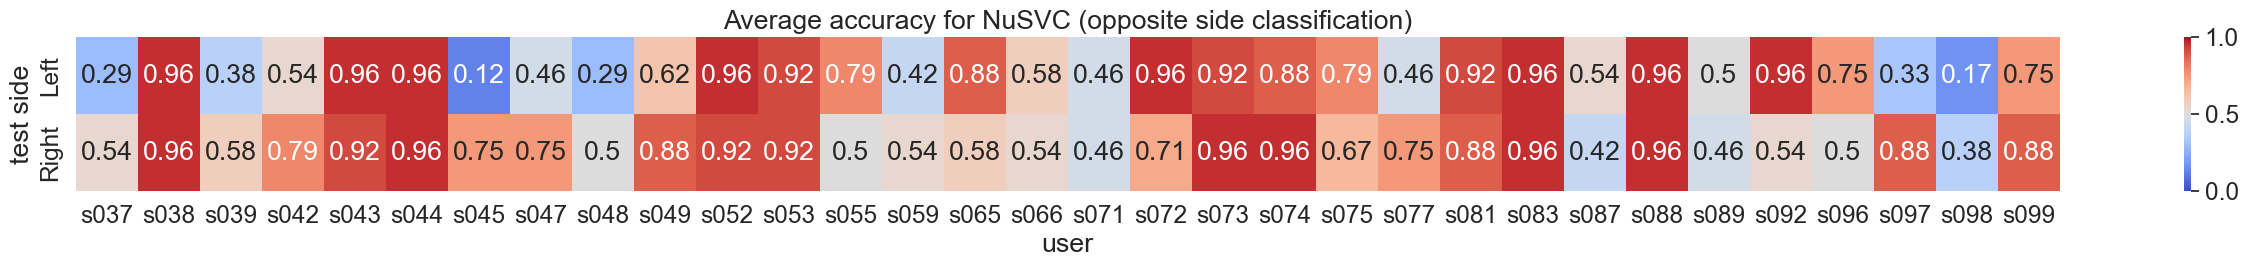

In [70]:
data_to_plot2 = data_to_plot.groupby(['user', 'test side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (opposite side classification)")
plt.show()

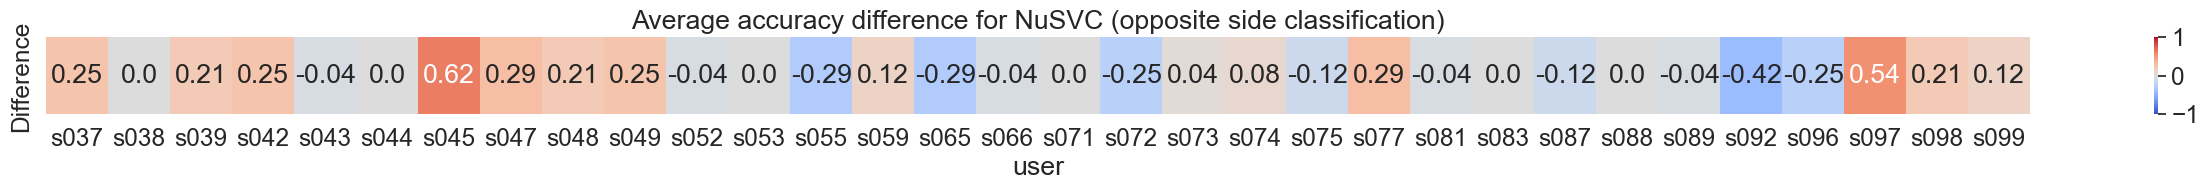

In [71]:
data_to_plot2 = data_to_plot.groupby(['user', 'test side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
data_to_plot3 = data_to_plot2.iloc[1,:] - data_to_plot2.iloc[0,:]
data_to_plot3 = DataFrame(data_to_plot3, columns=['Difference']).T

plt.figure(figsize=(len(data_to_plot3.columns),1))
ax = sns.heatmap(data_to_plot3, 
            yticklabels=['Difference'],
            cmap='coolwarm', 
            annot=data_to_plot3.round(decimals=2).values,
            vmin=-1, vmax=1,
            center=0,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy difference for {model_selected} (opposite side classification)")
plt.show()

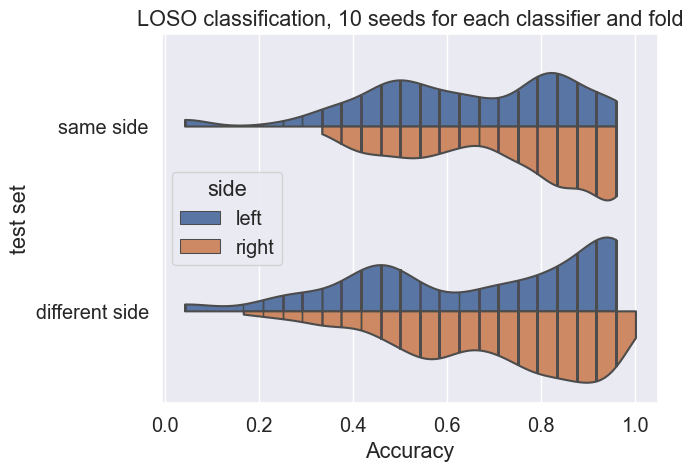

In [22]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", "same side")
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", "same side")
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", "different side")
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", "different side")
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx, *selected_results_lxrx, *selected_results_rxlx], columns=[metrics_selected, "side", "test set"])
ax = violinplot(data_to_plot, x=metrics_selected, y="test set", hue='side', split=True, inner='stick', cut=0)
plt.title("LOSO classification, 10 seeds for each classifier and fold")
# ax.set_xlim(0.5, 1.0)
plt.show()